# Kaggle Competition: Don't Get Kicked
## General Procedure
For this project, I will start from going through the data and identifying some basic properties of the data. Then, I will preprocess and reformat the data. After that, I am going to fit the data into a Extreme Gradient Boosting model (as most Kagglers do :>). Eventually, I will give some analysis on the prediction results.

## Data Exploration
We first need to import the data. Variable `train` is the training data without label column `IsBadBuy` and the first `RefId` column, and `test` is the testing data. Ground truth labels are stored in variable `lab`.

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt

train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
lab = train['IsBadBuy']
ntrain = len(train)
train = train.drop('IsBadBuy',axis=1)
train = train.drop('RefId',axis=1)
test = test.drop('RefId',axis=1)
train.head()

/Users/weiqingyu/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020



After importing the data, we want to have some basic insights into the data. The first thing that I check is the percentage of "kicks" in the training set. As it shows below, there is only 12% of the data that have been labeled as 1, which means random guessing (always predicts 0) has 88% accuracy. In terms of prediction accuracy, we do not want to have any model that has accuracy lower than 88%. Also, this indicates that we should use AUC, Gini Index, or weighted accuracy as a evaluation metric. The reason is that although "kicks" don't happens a lot, the loss of not identifying a "kick" is usually greater than misjudge a "non-kick". Therefore, we probably want to put more weights to the True Positive cases when calculating accuracy. 

Also, I examine the correlation coeffients among the numerical variables in the data. Since multicollinearity is usually a big problem in prediction models. And as it shows below, there are some highly correlated variables, e.g. 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', and etc. These variables corresponds to the light area in the heatmap.


Ratio of kicked case: 0.122987545045
Index(['VehYear', 'VehicleAge', 'WheelTypeID', 'VehOdo',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO',
       'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost'],
      dtype='object')


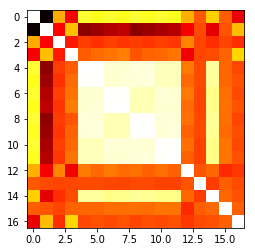

In [36]:
print('Ratio of kicked case:', sum(lab==1)/len(lab))
datcheck = train.loc[:,train.dtypes!=object].sample(1000).values
datcheck[np.isnan(datcheck)]=0
cor1 = np.corrcoef(datcheck.transpose())
print(train.columns[train.dtypes!=object])
plt.imshow(cor1, cmap='hot', interpolation='nearest')
plt.show()

I also check missing entries in the data. As it shows below, for most variables, there is not much missing entries. As for "PRIMEUNIT" and "AUCGUART", most of their entries are `NaN`. In general, I think missing data is not a big issue in this problem.

In [38]:
train.isnull().sum()

PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurrentAuctionAveragePrice          315
MMRCurrentAuctionCleanPrice            315
MMRCurrentRetailAveragePrice           315
MMRCurrentR

## Data Preprocessing
After some basic exploration of data, I am ready to process the data. First, I convert the `PurchDate` column from string to numeric (timestamp).  

In [40]:
train['PurchDate'] = pd.to_datetime(train['PurchDate']).values.astype(np.int64)/1000000000000
test['PurchDate'] = pd.to_datetime(test['PurchDate']).values.astype(np.int64)/1000000000000

Then I want to deal with the categorical variables in the data. For this basic model, I just convert all the categorical variables to dummy variables.

In [41]:
aldat = pd.concat([train,test],ignore_index=True)
aldat = pd.get_dummies(aldat)
train = aldat.iloc[:ntrain,].values
test = aldat.iloc[ntrain:,].values

Then, as I have discussed previously, missing data is not really a big issue here. Consequently, I just set all of the `NaN` to 0.

In [42]:
train[np.isnan(train)] = 0
test[np.isnan(test)] = 0
train.shape

(72983, 2339)

As it shows above, dimension of training dataset expands to 2339, which is too large. Besides, I have identified multicollinearity in this data. Therefore, PCA is applied to reduce dimension.

In [43]:
pcamodel = PCA(n_components=40)
pcamodel.fit(train)

PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [44]:
train = pcamodel.transform(train)
test = pcamodel.transform(test)

## Model Fitting
After processing the data, we are ready to fit the data into the model. Before running the model, I seperated 3% of training data out as the validation set.

In [59]:
samp = np.random.rand(ntrain)<0.97
train, lab1, cross, lab2 = train[samp], lab[samp], train[~samp], lab[~samp]
xgtest = xgb.DMatrix(test)
xgtrain = xgb.DMatrix(train,label=lab1)
xgeval = xgb.DMatrix(cross,label=lab2)
evallist = [(xgtrain,'train'),(xgeval,'val')]

/Users/weiqingyu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 70768 but corresponding boolean dimension is 72983
  from ipykernel import kernelapp as app


IndexError: index 70768 is out of bounds for axis 0 with size 70768

The parameters of XGBoost are set as below. Personally, I think the important parameters are:
* `max_depth`: Controls the maximum depth of the decision tree. It directly affects the complexity of the model.
* `num_boost_round`: Number of tree to build. Also directly affacts the complexity of the model.
* `lambda` and `alpha`: These two parameters regularize the model and prevents overfitting.

In [67]:
param = {'max_depth':12, 'eta':0.1, 'silent':1, 'objective':'binary:logistic',
         'subsample':0.3,'lambda':1.5,'alpha':1, 'eval_metric':['auc','error']}
xgmodel = xgb.train(param,xgtrain,num_boost_round=30,evals=evallist)

[0]	train-auc:0.71405	train-error:0.101656	val-auc:0.719281	val-error:0.108804
[1]	train-auc:0.74162	train-error:0.098929	val-auc:0.740752	val-error:0.102032
[2]	train-auc:0.751899	train-error:0.097558	val-auc:0.747313	val-error:0.099774
[3]	train-auc:0.758417	train-error:0.09736	val-auc:0.745594	val-error:0.099323
[4]	train-auc:0.763716	train-error:0.097544	val-auc:0.748512	val-error:0.099323
[5]	train-auc:0.770915	train-error:0.097601	val-auc:0.746738	val-error:0.09842
[6]	train-auc:0.778028	train-error:0.097473	val-auc:0.750731	val-error:0.097968
[7]	train-auc:0.780955	train-error:0.097459	val-auc:0.752585	val-error:0.097968
[8]	train-auc:0.786167	train-error:0.097233	val-auc:0.750243	val-error:0.097968
[9]	train-auc:0.793588	train-error:0.097021	val-auc:0.751027	val-error:0.09842
[10]	train-auc:0.800335	train-error:0.096739	val-auc:0.747499	val-error:0.098871
[11]	train-auc:0.806586	train-error:0.096555	val-auc:0.743307	val-error:0.097968
[12]	train-auc:0.812068	train-error:0.09631

## Result Analysis
After we train the model, we can get the prediction on the validation set. The output of our prediction is a probability. As it shows below, the false negative rate is pretty high, and that is the part that should be improved.

In [68]:
pred = xgmodel.predict(xgeval)

In [81]:
lab2.index=range(len(lab2))
xpred = pred>0.5
print(sum(np.logical_and(xpred==1,lab2==1)),sum(np.logical_and(xpred==1,lab2==0)))
print(sum(np.logical_and(xpred==0,lab2==1)),sum(np.logical_and(xpred==0,lab2==0)))


61 9
206 1939


## Improvements
* Modify the objective function to make it more suitable for our problem, where we want to put more focus on the True Positive cases.
* Carefully check if there is categorical variables that is ordinal. For those variables, we should not convert them to dummy variables.
* Deal with the multicollinearity problem through feature engineering. Even though we applied PCA, which deals with multicollinearity in some way, highly dependent predictors still influence the performance of model as discussed in [here](https://stats.stackexchange.com/questions/50537/should-one-remove-highly-correlated-variables-before-doing-pca). 
* Implement ensemble methods to combine results from multiple algorithms usually helps to boost the accuracy.
* Use feature engineering and exploratory analysis to create better features.